# 합성곱 신경망을 사용한 이미지 분류

In [1]:
from torchvision.datasets import FashionMNIST

fm_train=FashionMNIST(root='.',train=True,download=True)
fm_test=FashionMNIST(root='.',train=False,download=True)

train_input=fm_train.data
train_target=fm_train.targets
train_scaled=train_input.reshape(-1,1,28,28)/255.0

from sklearn.model_selection import train_test_split

train_scaled,val_scaled,train_target,val_target=train_test_split(
    train_scaled,
    train_target,
    test_size=0.2,
    random_state=42
)

In [2]:
import torch.nn as nn

model=nn.Sequential()
model.add_module('con1',nn.Conv2d(1,32,kernel_size=3,padding='same')) #인풋은 채널이 1개, 필터가 32개(출력 채널이 32)
model.add_module('relu1',nn.ReLU())
model.add_module('pool1',nn.MaxPool2d(2))

model.add_module('conv2',nn.Conv2d(32,64,kernel_size=3,padding='same'))
model.add_module('relu2',nn.ReLU())
model.add_module('pool2',nn.MaxPool2d(2))
model.add_module('flatten',nn.Flatten())

In [4]:
import torch
outputs=model(torch.ones(1,1,28,28))
print(outputs.shape)

torch.Size([1, 3136])


In [5]:
model.add_module('dense1',nn.Linear(3136,100))
model.add_module('relu3',nn.ReLU())
model.add_module('dropout',nn.Dropout(0.3))
model.add_module('dense2',nn.Linear(100,10))

In [6]:
import torch

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters())

In [7]:
from torch.utils.data import TensorDataset,DataLoader

train_dataset=TensorDataset(train_scaled,train_target)
val_dataset=TensorDataset(val_scaled,val_target)

train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False)

In [10]:
train_hist=[]
val_hist=[]
patience=2
best_loss=-1
early_stopping_counter=0

epoches=20
for epoch in range(epoches):
    model.train()
    train_loss=0
    for inputs,targets in train_loader:
        inputs,targets=inputs.to(device),targets.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,targets)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    model.eval()
    val_loss=0
    with torch.no_grad():
        for inputs,targets in val_loader:
            inputs,targets=inputs.to(device),targets.to(device)
            outputs=model(inputs)
            loss=criterion(outputs,targets)
            val_loss+=loss.item()

    train_loss=train_loss/len(train_loader)
    val_loss=val_loss/len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f'에포크:{epoch+1},',
          f'훈련 손실:{train_loss:.4f}, 검증 손실:{val_loss:.4f}')
    if best_loss==-1 or val_loss<best_loss:
        best_loss=val_loss
        early_stopping_counter=0
        torch.save(model.state_dict(),'best_cnn_model.pt')
    else:
        early_stopping_counter+=1
        if early_stopping_counter>=patience:
            print(f'{epoch+1}번째 에포크에서 조기 종료되었습니다.')
            break

에포크:1, 훈련 손실:0.5324, 검증 손실:0.3351
에포크:2, 훈련 손실:0.3480, 검증 손실:0.3002
에포크:3, 훈련 손실:0.3013, 검증 손실:0.2597
에포크:4, 훈련 손실:0.2696, 검증 손실:0.2408
에포크:5, 훈련 손실:0.2481, 검증 손실:0.2569
에포크:6, 훈련 손실:0.2263, 검증 손실:0.2363
에포크:7, 훈련 손실:0.2035, 검증 손실:0.2431
에포크:8, 훈련 손실:0.1912, 검증 손실:0.2438
8번째 에포크에서 조기 종료되었습니다.


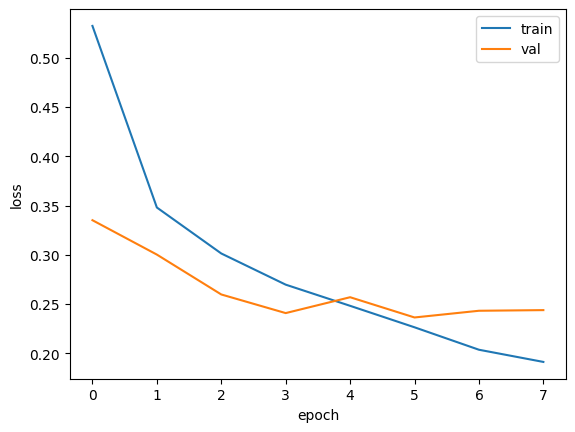

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_hist,label='train')
plt.plot(val_hist,label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [12]:
model.load_state_dict(torch.load('best_cnn_model.pt',weights_only=True))

model.eval()
corrects=0
with torch.no_grad():
    for inputs,targets in val_loader:
        inputs,targets=inputs.to(device),targets.to(device)
        outputs=model(inputs)
        predicts=torch.argmax(outputs,1)
        corrects+=(predicts==targets).sum().item()
accuracy=corrects/len(val_dataset)
print(f'검증 정확도: {accuracy:.4f}')

검증 정확도: 0.9153


In [13]:
test_scaled=fm_test.data.reshape(-1,1,28,28)/255.0
test_target=fm_test.targets

test_dataset=TensorDataset(test_scaled,test_target)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [15]:
model.eval()
corrects=0
with torch.no_grad():
    for inputs,targets in test_loader:
        inputs,targets=inputs.to(device),targets.to(device)
        outputs=model(inputs)
        predicts=torch.argmax(outputs,1)
        corrects+=(predicts==targets).sum().item()
accuracy=corrects/len(test_dataset)
print(f'테스트 정확도: {accuracy:.4f}')

테스트 정확도: 0.9103
